In [61]:
%pylab inline
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
from pandas import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm
from datetime import datetime
import scipy.stats as stats
from bs4 import BeautifulSoup
import urllib2
from IPython.display import display, HTML
#Set default plot size for session
pylab.rcParams['figure.figsize'] = 20, 20
import matplotlib.patches as mpatches

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


## Plan:
- Do univariate regression of total calls versus date
- Do multivariate regression that includes more date data (year, holiday etc...)
- Do multivariate regression for some other response variable in dataset

In [62]:
fname = "/Users/nicholasharrigan/R/data/cfpb_Consumer_Complaints.csv"

Read dataframe from CSV

In [63]:
df = pd.read_csv(fname, index_col='Date received')

Convert index to datetime object

In [64]:
date_vals = [pd.datetime.strptime(x, '%m/%d/%Y') for x in df.index]
df.index = pd.DatetimeIndex(date_vals)

Count total number of calls on each date

In [65]:
group_date = df.groupby(lambda x: x.date())
total_calls = group_date.size()

Split into weekend and weekday calls

In [66]:
weekends = total_calls[total_calls.index.map(lambda x: x.weekday() in [5,6])]
weekdays = total_calls[total_calls.index.map(lambda x: x.weekday() in range(5))]

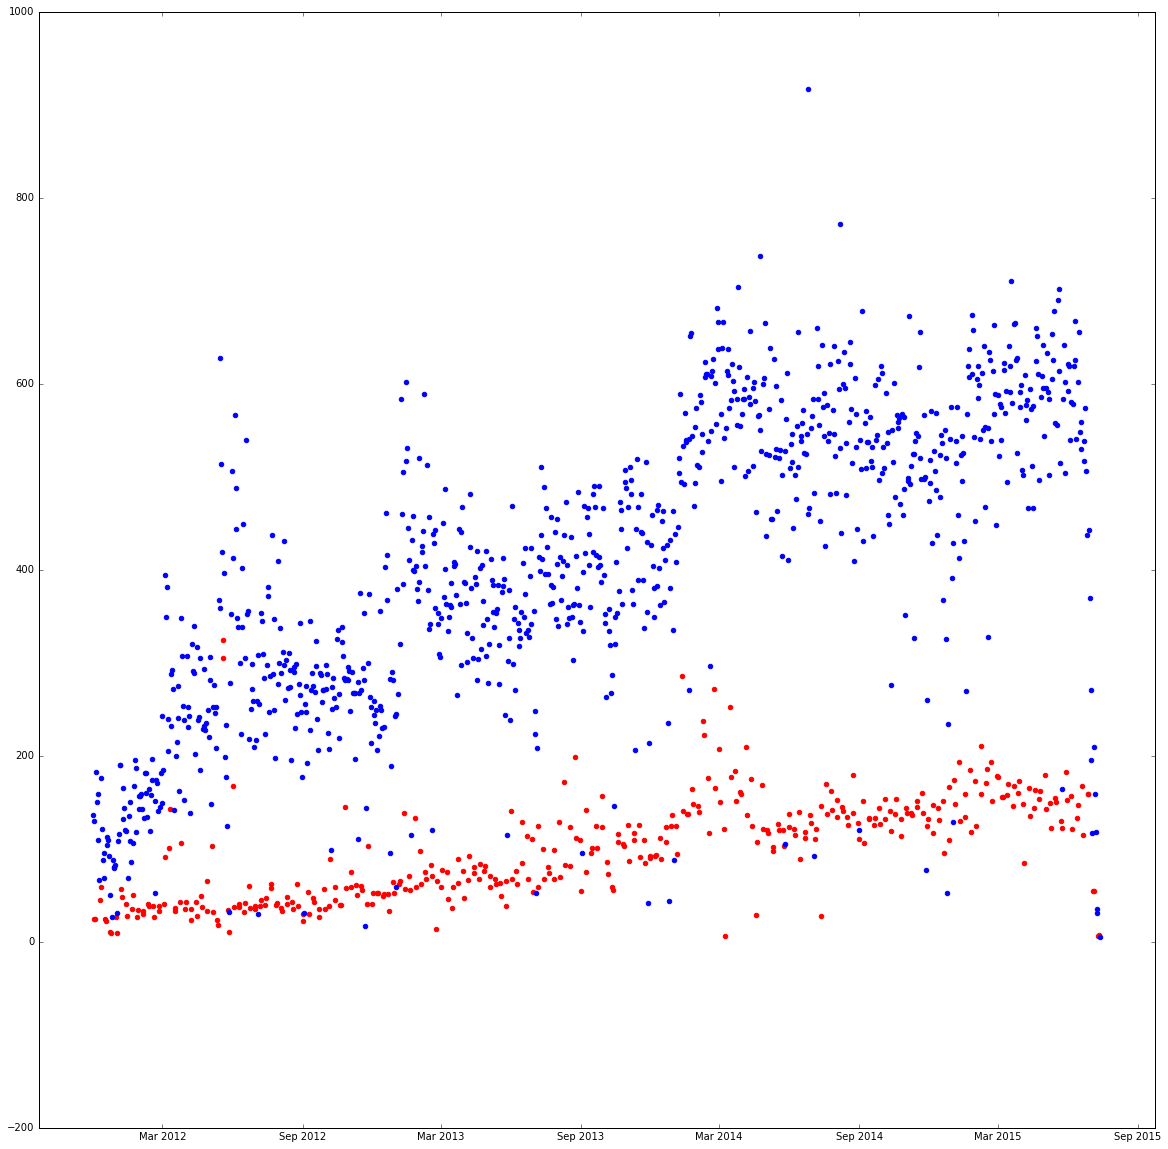

In [67]:
plt.scatter(weekends.index, weekends.values, color = 'red');
plt.scatter(weekdays.index, weekdays.values, color = 'blue');

Look at distribution of calls for a given year

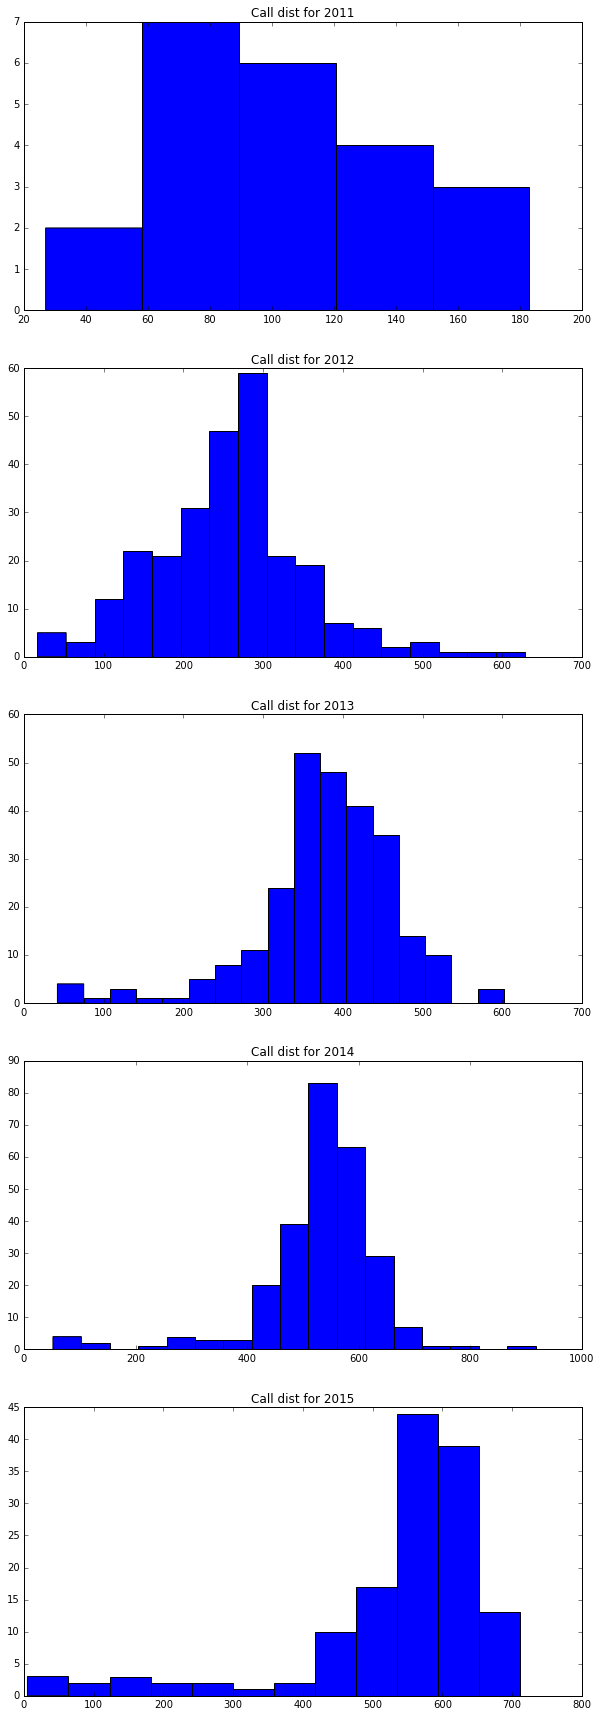

In [68]:
weekdays_yr = weekdays.groupby(lambda x: x.year)
fig, ax = subplots(weekdays_yr.ngroups, figsize=(10,30))
for idx, yr in enumerate(weekdays_yr.groups.keys()): 
    yr_vals = weekdays_yr.get_group(yr)
    ax[idx].hist(yr_vals, bins=ceil(sqrt(len(yr_vals))));
    ax[idx].set_title('Call dist for %s' %str(yr))

In [79]:
from sklearn.preprocessing import PolynomialFeatures, scale, RobustScaler, StandardScaler
from sklearn.linear_model import ElasticNet, Ridge
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split, KFold
from sklearn.covariance import EllipticEnvelope

In [70]:
# Split weekends data into training and test split (cross validate on training data)


### Outliers:

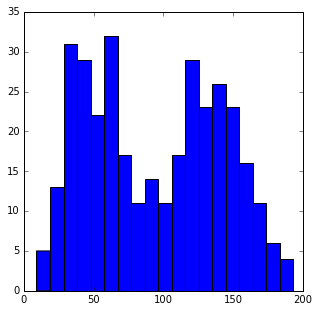

In [89]:
# Check whether repsonse dimension is gaussian distributed in order to use Elliptical Envelope
# under assumption fo being gaussian
plt.hist(weekends.values, bins=ceil(sqrt(len(weekends))));
fig = matplotlib.pyplot.gcf()
fig.set_figheight(5)
fig.set_figwidth(5)

Looks bi-modal, but might still do ok with multivariate gaussian

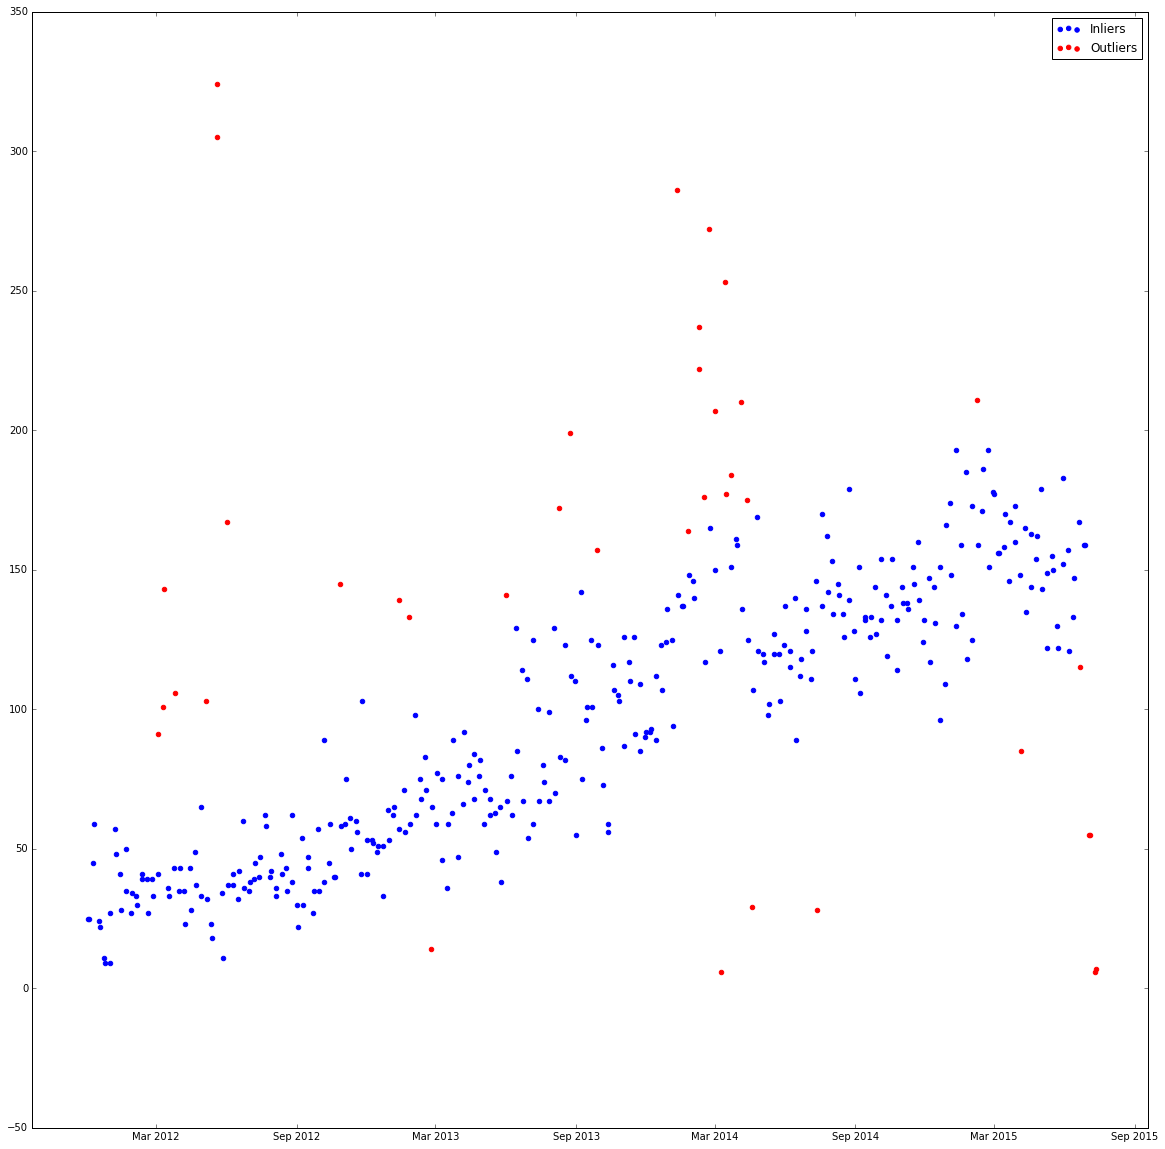

In [71]:
# Remove outliers using Elliptical Envelope
concat_vals = np.hstack([np.arange(len(weekends))[:, np.newaxis],weekends.values[:, np.newaxis]])
env = EllipticEnvelope()
env.fit(concat_vals)
pred = aa.predict(concat_vals)
plt.scatter(weekends.index[pred==1], weekends.values[pred==1], color='blue', label='Inliers')
plt.scatter(weekends.index[pred==-1], weekends.values[pred==-1], color='red', label='Outliers')
plt.legend()
weekends = weekends[pred==1]

-0.0399514160069
{'poly__degree': 4, 'enet__l1_ratio': 1.0, 'enet__alpha': 1.0000000000000001e-05}


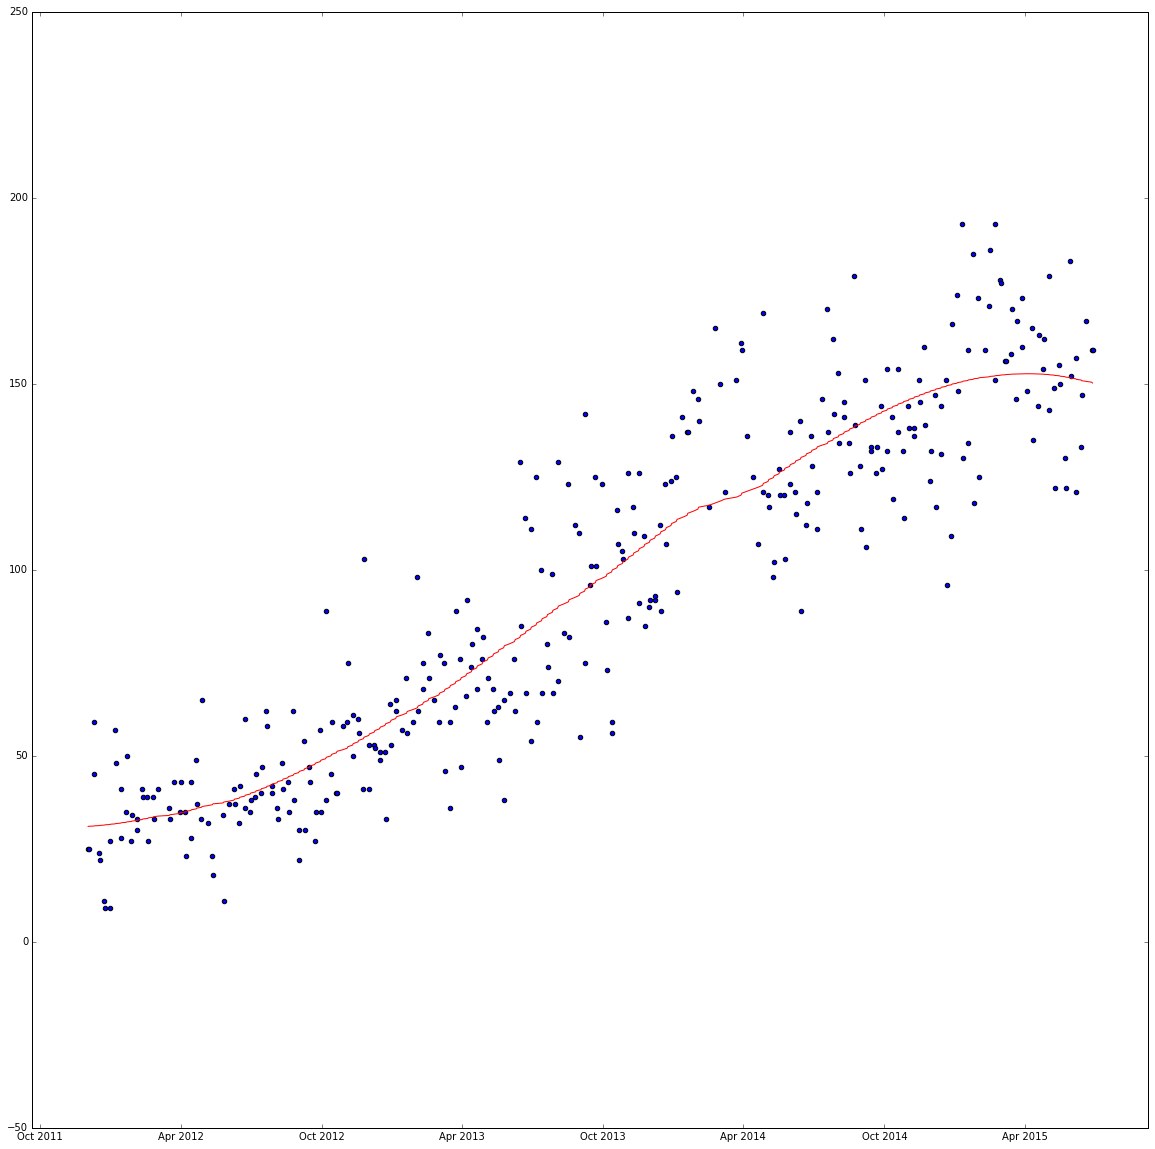

In [83]:
pipe = Pipeline([('poly', PolynomialFeatures(5)), ('scale', StandardScaler()), ('enet',ElasticNet(alpha= 1.0000000000000001e-05, l1_ratio= 1.0))])
alpha_vals = np.array([np.linspace(10**-x, 10**(-x+1),2) for x in range(-6,6,1)]).ravel()
l1ratio_vals = np.linspace(0,1,5)
params = {'poly__degree': np.arange(11), 'enet__alpha': alpha_vals, 'enet__l1_ratio': l1ratio_vals}
scaleGS = GridSearchCV(pipe, params, cv=10)
scaleGS.fit(np.arange(len(weekends))[:, np.newaxis], weekends.values[:, np.newaxis])
est = scaleGS.best_estimator_
best_train = est.predict(np.arange(len(weekends))[:, np.newaxis])
best_train = pd.Series(best_train)
best_train.index = weekends.index
plt.scatter(weekends.index, weekends.values)
plt.plot(best_train.index, best_train.values, color='red')
print scaleGS.best_score_
print scaleGS.best_params_

**FIRST READ THIS ON GENERAL PREPROCESSING**
* http://scikit-learn.org/stable/modules/preprocessing.html
* http://stats.stackexchange.com/questions/8891/data-preparation-for-regression

**THEN DO THESE PRE-PROCESSINGS:**
* Feature scaling - - otherwise we need to consider a large range of alpha values. http://sebastianraschka.com/Articles/2014_about_feature_scaling.html#standardization-and-min-max-scaling
* Outlier detection/removal: 
    * http://scikit-learn.org/stable/modules/outlier_detection.html
    * http://www.holehouse.org/mlclass/15_Anomaly_Detection.html
    * http://scikit-learn.org/stable/auto_examples/applications/plot_outlier_detection_housing.html
* Feature selection - http://scikit-learn.org/stable/modules/feature_selection.html

In [24]:
# Create pipeline for adding polynomial features to univariate data and then Enet estimator
uni_pipe = Pipeline([('poly', PolynomialFeatures()),('enet', ElasticNet())])
# define alpha and lratio values to then use in parameter grid
alpha_vals = np.array([10**x for x in range(-100,100,10)])
# alpha_vals = np.array([np.linspace(10**(-x), 10**(-x+1), 2) for x in range(1,8)]).ravel()
l1ratio_vals = np.linspace(0,1,10)
# Define polynomial degree values to use in parameter grid
degree_vals = np.arange(1,5)
param_grid = {'poly__degree': degree_vals, 'enet__alpha': alpha_vals, 'enet__l1_ratio': l1ratio_vals}
# Explicitly pass KFolds object as cv so that can have GridSearch shuffle data before CV 
uniGS = GridSearchCV(uni_pipe, param_grid, scoring='mean_squared_error', cv=KFold(len(weekends),n_folds=10,shuffle=True), n_jobs=-1, iid=False)
uniGS.fit(arange(len(weekends))[:, np.newaxis], weekends.values[:, np.newaxis]);

-1490.86079563
{'poly__degree': 4, 'enet__l1_ratio': 0.0, 'enet__alpha': 10000000000}


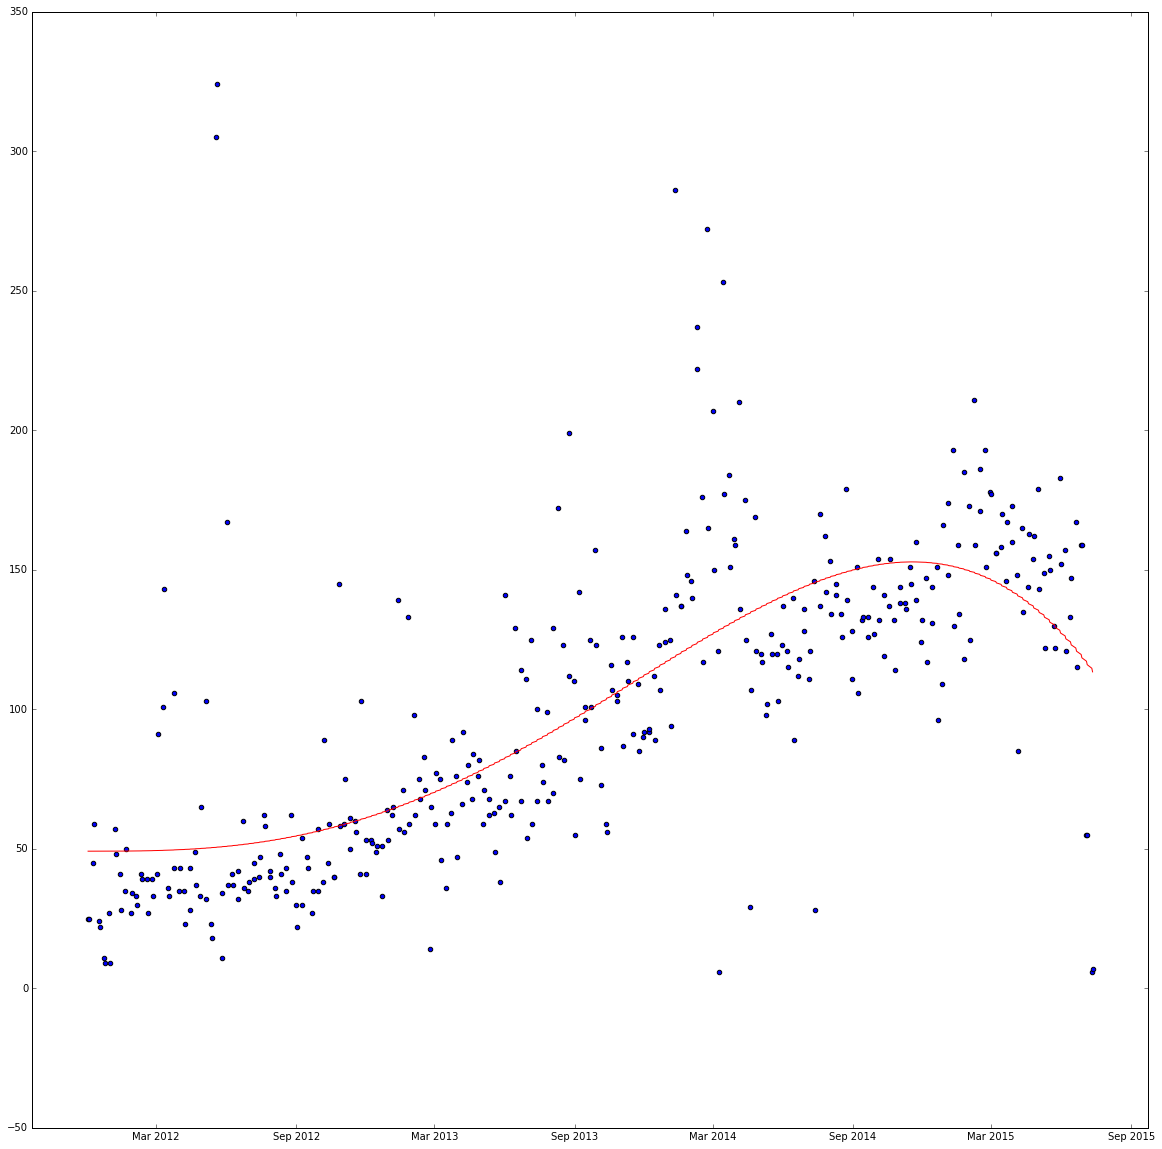

In [25]:
bestfit = uniGS.best_estimator_
best_train = bestfit.predict(arange(len(weekends))[:, np.newaxis])
best_train = pd.Series(best_train)
best_train.index = weekends.index
plt.scatter(weekends.index, weekends.values)
plt.plot(best_train.index, best_train.values, color='red')
print uniGS.best_score_
print uniGS.best_params_